<a href="https://colab.research.google.com/github/adityatiwari-13/Python-projects/blob/main/Model_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shap
import joblib

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [ ]:
import pandas as pd
df = pd.read_csv("/content/WHO_mental_health_dataset_1000.csv")
print("Dataset Loaded Successfully")
print(df.head())

Dataset Loaded Successfully
     Country  Age  Gender  Sleep_Hours  Work_Stress_Level  Anxiety_Score  \
0  Australia   27   Other            5                  3              0   
1     France   47  Female            4                  7             19   
2        USA   32   Other            5                  2              6   
3      Japan   20    Male            5                  5             18   
4    Germany   27  Female            3                  2             17   

   Depression_Score  Social_Support_Level  Screen_Time_Hours  \
0                23                     1                  7   
1                 3                     3                  6   
2                22                     3                  6   
3                23                     6                 10   
4                 4                     9                  4   

  Mental_Health_Status  
0           Depression  
1           Depression  
2           Depression  
3           Depression  
4    

In [ ]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Country               1000 non-null   object
 1   Age                   1000 non-null   int64 
 2   Gender                1000 non-null   object
 3   Sleep_Hours           1000 non-null   int64 
 4   Work_Stress_Level     1000 non-null   int64 
 5   Anxiety_Score         1000 non-null   int64 
 6   Depression_Score      1000 non-null   int64 
 7   Social_Support_Level  1000 non-null   int64 
 8   Screen_Time_Hours     1000 non-null   int64 
 9   Mental_Health_Status  1000 non-null   object
dtypes: int64(7), object(3)
memory usage: 78.3+ KB
None
               Age  Sleep_Hours  Work_Stress_Level  Anxiety_Score  \
count  1000.000000  1000.000000         1000.00000    1000.000000   
mean     40.196000     5.577000            5.06100       9.958000   
std      13.418108     1.724832

Mental_Health_Status
Depression    623
Stress        276
Normal        101
Name: count, dtype: int64


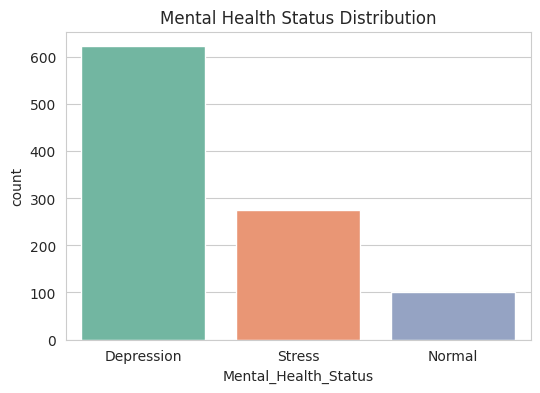

In [ ]:
print(df['Mental_Health_Status'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Mental_Health_Status', palette='Set2')
plt.title('Mental Health Status Distribution')
plt.show()


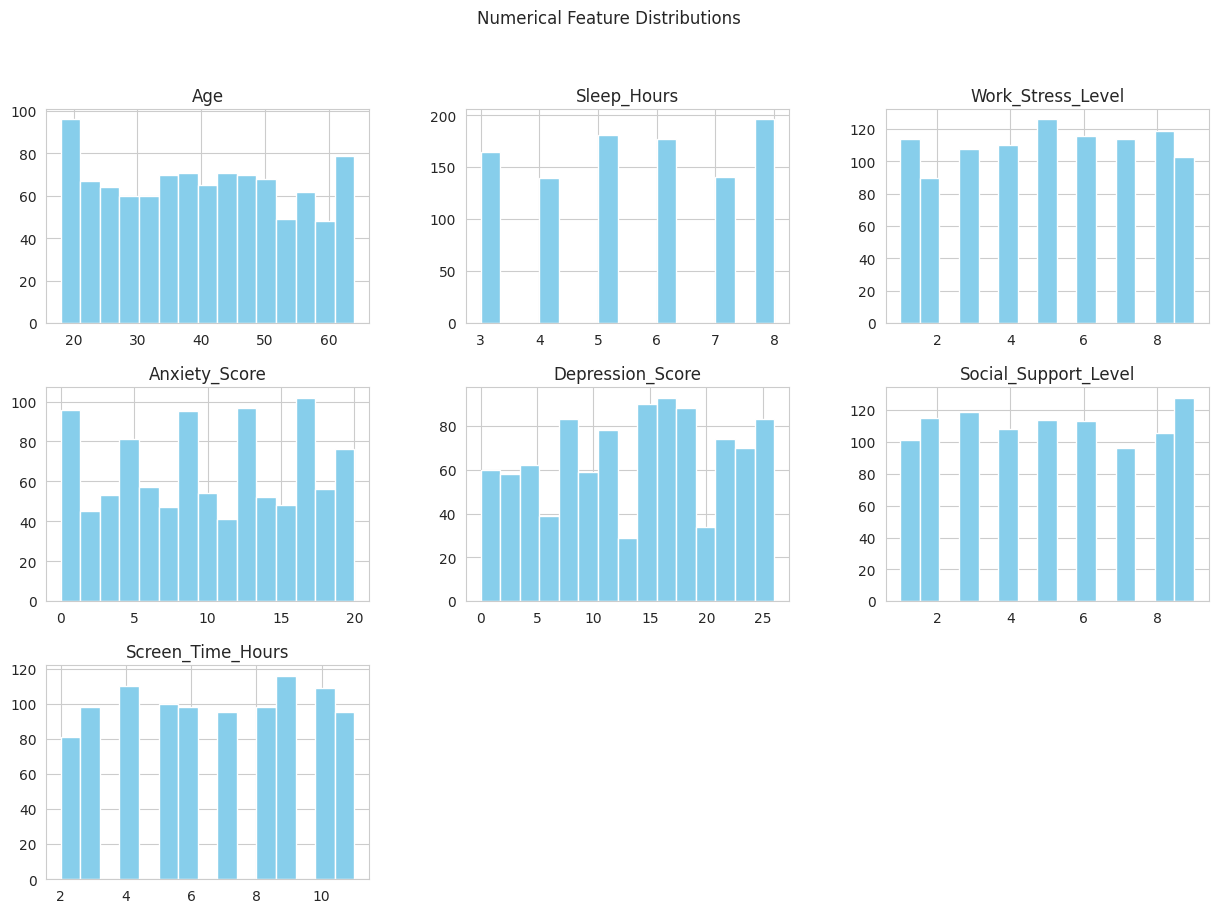

In [ ]:
num_features = ["Age","Sleep_Hours","Work_Stress_Level","Anxiety_Score",
                "Depression_Score","Social_Support_Level","Screen_Time_Hours"]

df[num_features].hist(figsize=(15,10), bins=15, color='skyblue')
plt.suptitle('Numerical Feature Distributions')
plt.show()

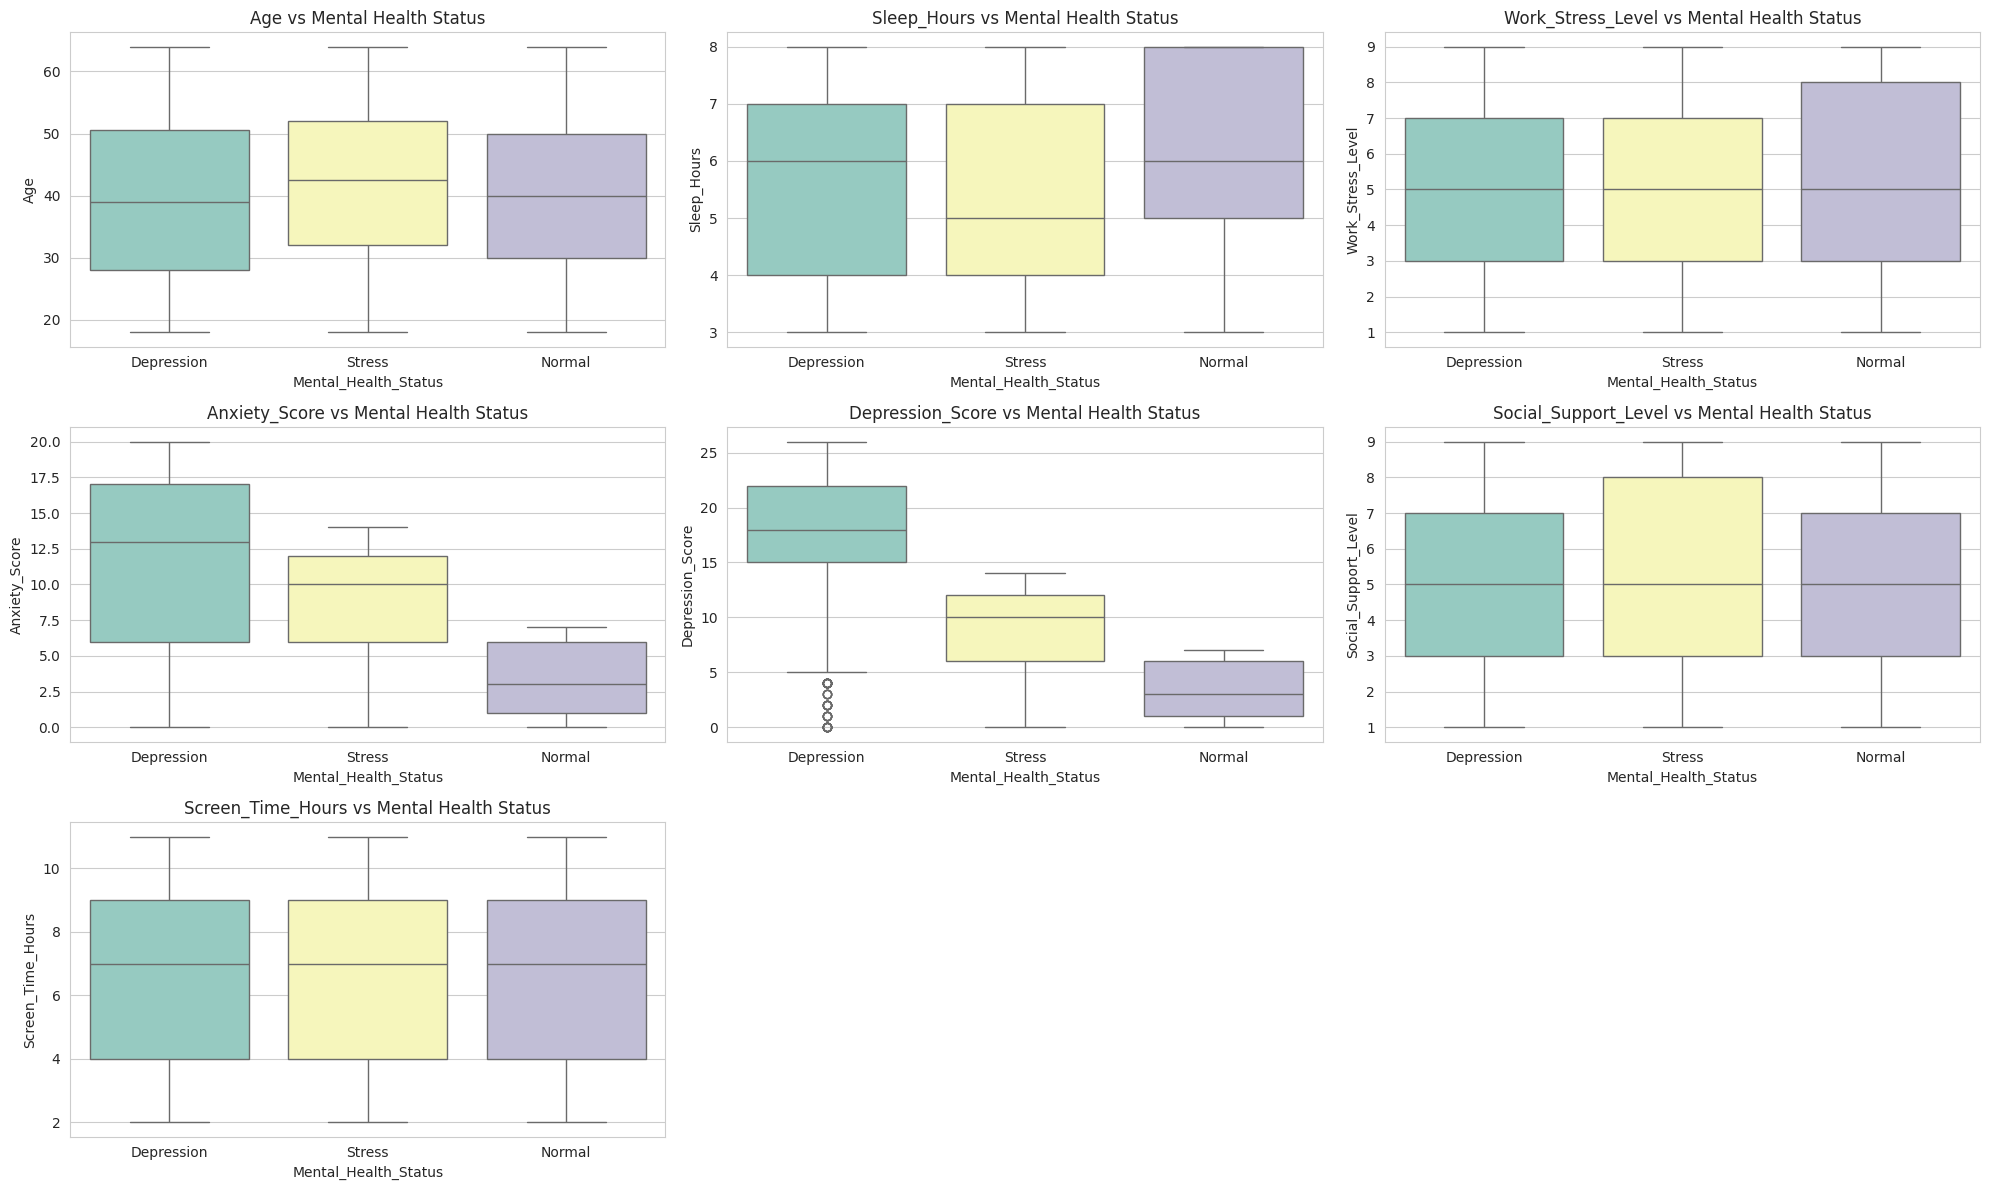

In [ ]:
plt.figure(figsize=(20,12))
for i, feature in enumerate(num_features):
    plt.subplot(3,3,i+1)
    sns.boxplot(x='Mental_Health_Status', y=feature, data=df, palette='Set3')
    plt.title(f'{feature} vs Mental Health Status')
plt.tight_layout()
plt.show()


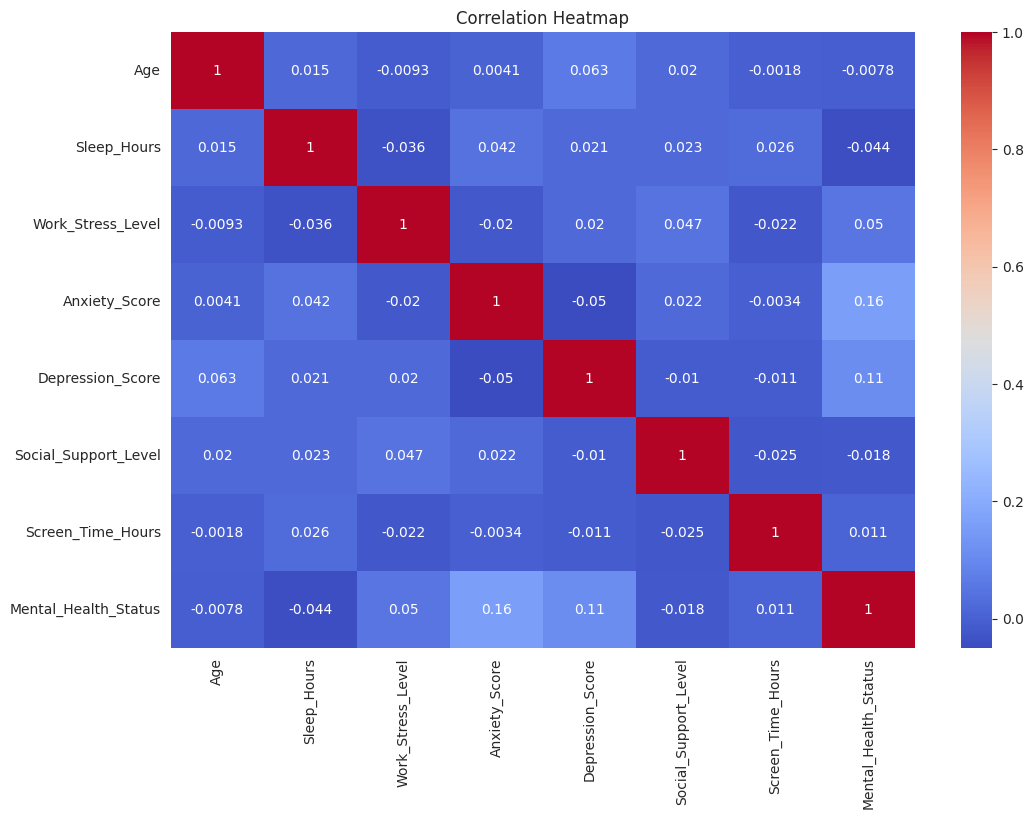

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# df and num_features are expected to be defined by previous cells

plt.figure(figsize=(12,8))
sns.heatmap(df[num_features + ['Mental_Health_Status']].apply(lambda x: pd.factorize(x)[0]).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
from scipy import stats
z_scores = np.abs(stats.zscore(df[num_features]))
outliers = np.where(z_scores > 3)
print(f"Outliers detected at indices: {outliers}")


Outliers detected at indices: (array([], dtype=int64), array([], dtype=int64))


In [ ]:
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])
le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])


In [ ]:
X = df.drop('Mental_Health_Status', axis=1)
y = df['Mental_Health_Status']
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

In [ ]:
X['Stress_to_Sleep'] = X['Work_Stress_Level'] / (X['Sleep_Hours']+1)
X['Anxiety_Depression_Ratio'] = (X['Anxiety_Score']+1) / (X['Depression_Score']+1)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)a


In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y_encoded)
print(f"Resampled dataset shape: {X_res.shape}, {np.bincount(y_res)}")


Resampled dataset shape: (1869, 11), [623 623 623]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")


Train Shape: (1495, 11), Test Shape: (374, 11)


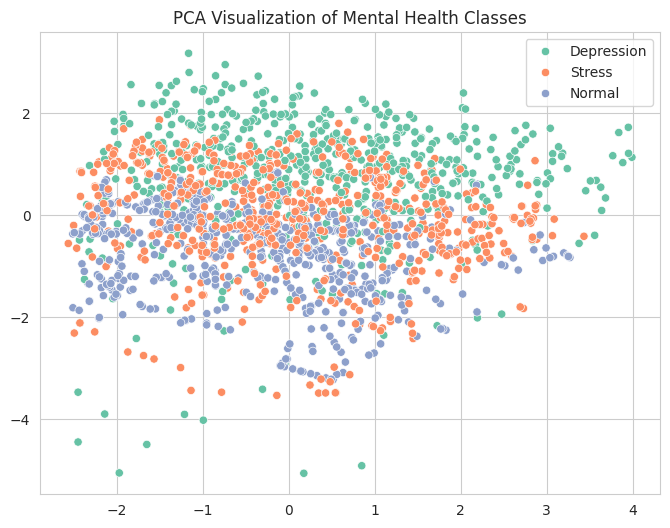

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_res)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=le_target.inverse_transform(y_res), palette='Set2')
plt.title("PCA Visualization of Mental Health Classes")
plt.show()

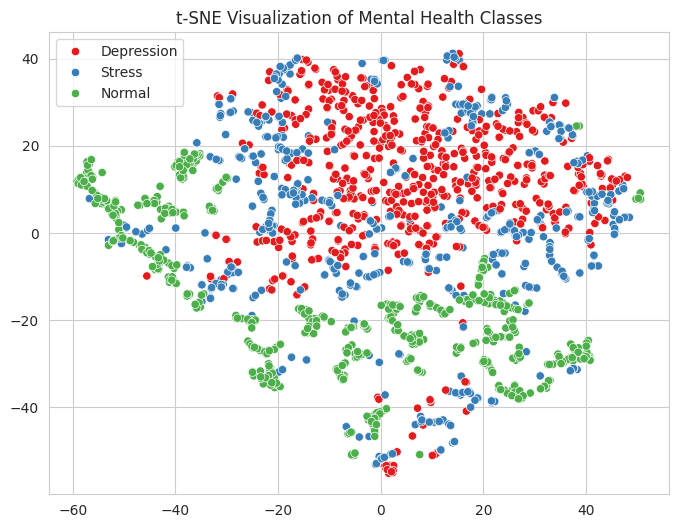

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_res)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=le_target.inverse_transform(y_res), palette='Set1')
plt.title("t-SNE Visualization of Mental Health Classes")
plt.show()


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    print(f"{name} trained successfully!")


Logistic Regression trained successfully!
Decision Tree trained successfully!
Random Forest trained successfully!
XGBoost trained successfully!
SVM trained successfully!
KNN trained successfully!



--- Logistic Regression ---
Accuracy: 0.8636363636363636
Classification Report:
               precision    recall  f1-score   support

  Depression       0.88      0.77      0.82       124
      Normal       0.93      0.99      0.96       125
      Stress       0.78      0.82      0.80       125

    accuracy                           0.86       374
   macro avg       0.86      0.86      0.86       374
weighted avg       0.86      0.86      0.86       374



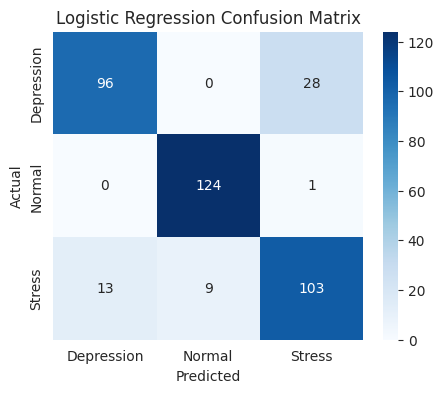


--- Decision Tree ---
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

  Depression       1.00      1.00      1.00       124
      Normal       1.00      1.00      1.00       125
      Stress       1.00      1.00      1.00       125

    accuracy                           1.00       374
   macro avg       1.00      1.00      1.00       374
weighted avg       1.00      1.00      1.00       374



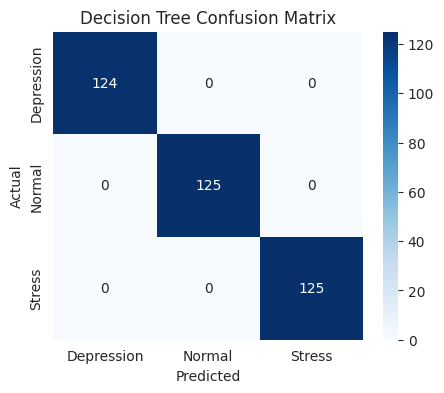


--- Random Forest ---
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

  Depression       1.00      1.00      1.00       124
      Normal       1.00      1.00      1.00       125
      Stress       1.00      1.00      1.00       125

    accuracy                           1.00       374
   macro avg       1.00      1.00      1.00       374
weighted avg       1.00      1.00      1.00       374



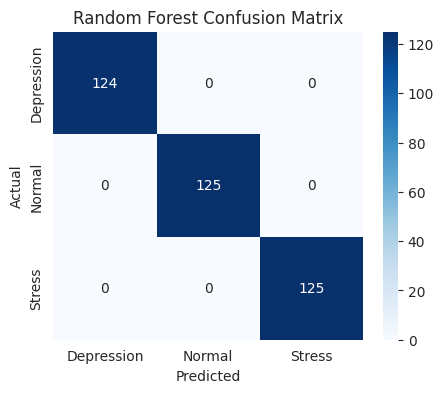


--- XGBoost ---
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

  Depression       1.00      1.00      1.00       124
      Normal       1.00      1.00      1.00       125
      Stress       1.00      1.00      1.00       125

    accuracy                           1.00       374
   macro avg       1.00      1.00      1.00       374
weighted avg       1.00      1.00      1.00       374



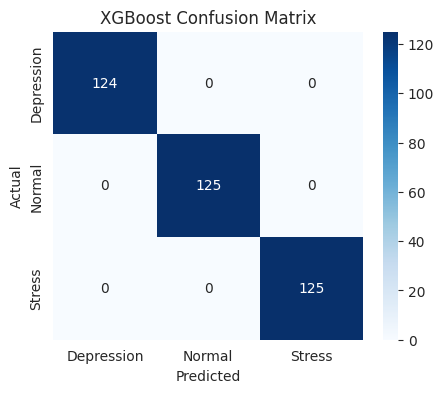


--- SVM ---
Accuracy: 0.9438502673796791
Classification Report:
               precision    recall  f1-score   support

  Depression       0.97      0.87      0.92       124
      Normal       0.98      1.00      0.99       125
      Stress       0.88      0.96      0.92       125

    accuracy                           0.94       374
   macro avg       0.95      0.94      0.94       374
weighted avg       0.95      0.94      0.94       374



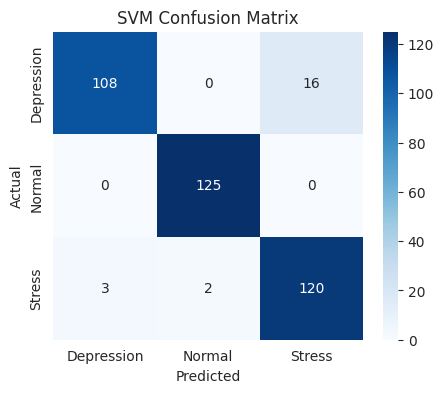


--- KNN ---
Accuracy: 0.893048128342246
Classification Report:
               precision    recall  f1-score   support

  Depression       0.96      0.81      0.88       124
      Normal       0.92      0.99      0.95       125
      Stress       0.81      0.88      0.85       125

    accuracy                           0.89       374
   macro avg       0.90      0.89      0.89       374
weighted avg       0.90      0.89      0.89       374



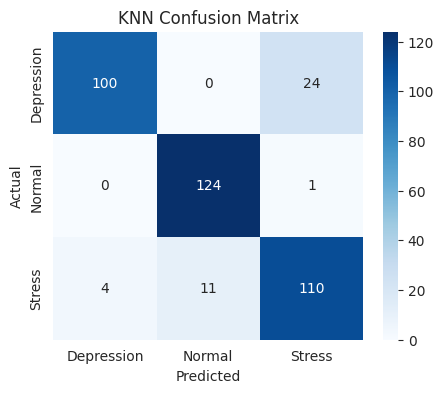

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le_target.classes_))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    return acc

model_accuracies = {}
for name, y_pred in predictions.items():
    acc = evaluate_model(y_test, y_pred, name)
    model_accuracies[name] = acc

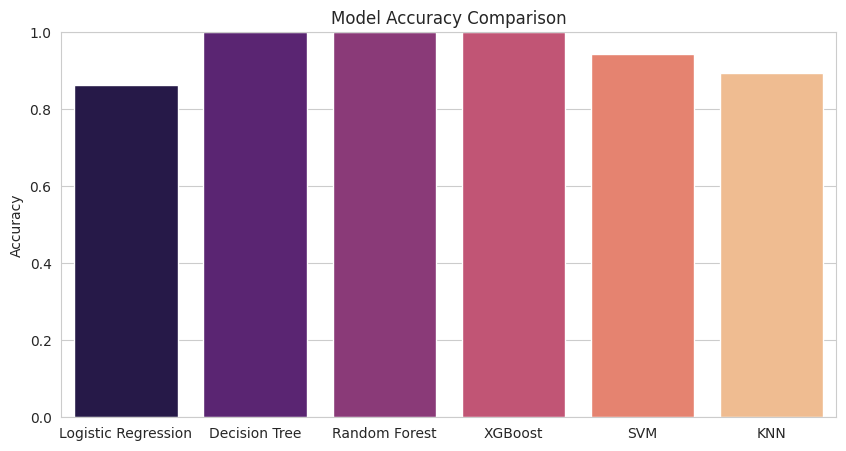

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette='magma')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


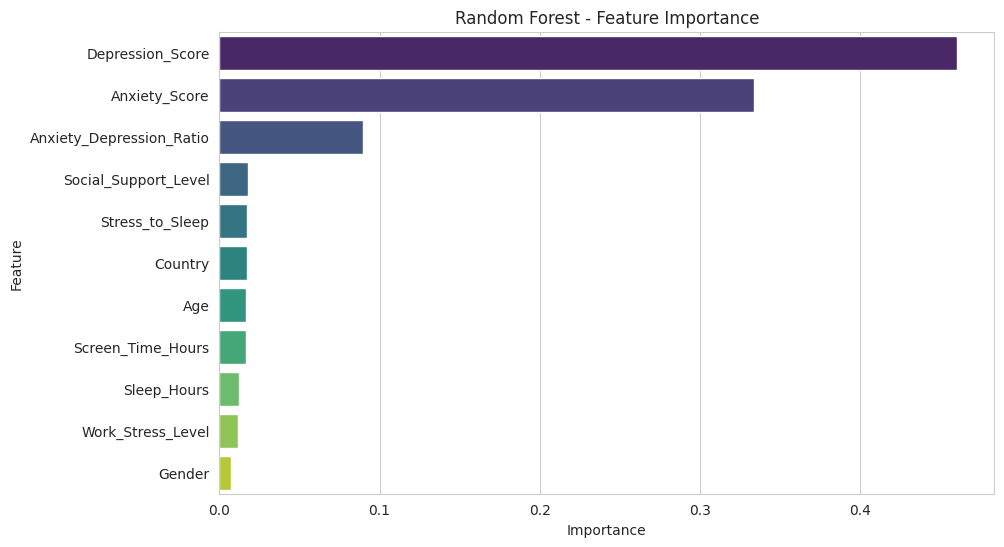

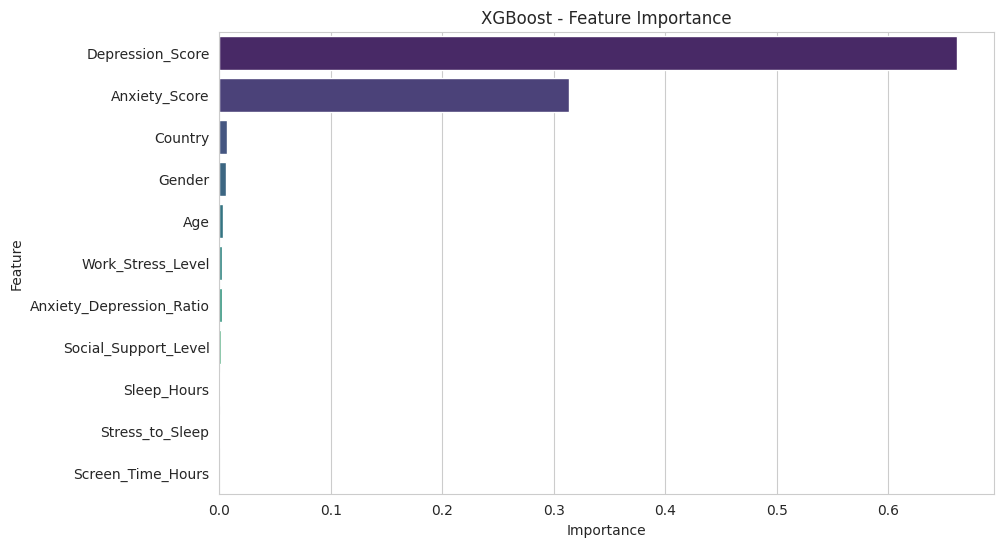

In [ ]:
def plot_feature_importance(model, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
        plt.figure(figsize=(10,6))
        sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
        plt.title(f"{model_name} - Feature Importance")
        plt.show()

plot_feature_importance(models["Random Forest"], "Random Forest")
plot_feature_importance(models["XGBoost"], "XGBoost")


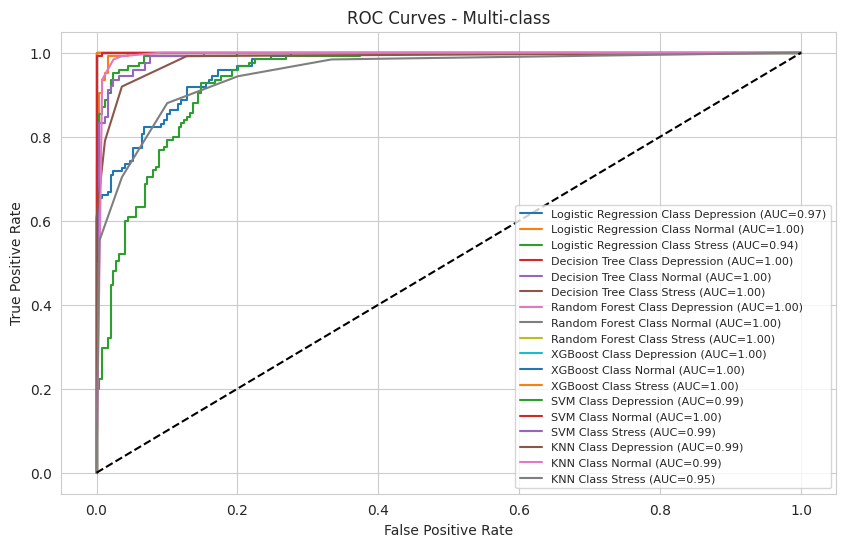

In [ ]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10,6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        for j in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, j], y_score[:, j])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} Class {le_target.classes_[j]} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves - Multi-class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize=8)
plt.show()

In [ ]:
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring='accuracy')
    print(f"{name} 5-Fold CV Accuracy: Mean={scores.mean():.3f}, Std={scores.std():.3f}")


Logistic Regression 5-Fold CV Accuracy: Mean=0.854, Std=0.019
Decision Tree 5-Fold CV Accuracy: Mean=1.000, Std=0.000
Random Forest 5-Fold CV Accuracy: Mean=1.000, Std=0.000
XGBoost 5-Fold CV Accuracy: Mean=1.000, Std=0.000
SVM 5-Fold CV Accuracy: Mean=0.890, Std=0.024
KNN 5-Fold CV Accuracy: Mean=0.765, Std=0.036


In [ ]:
param_grid = {'n_estimators':[100,200],'max_depth':[None,5,10],'min_samples_split':[2,5],'min_samples_leaf':[1,2]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("\nBest Random Forest Params:", grid_rf.best_params_)



Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}



--- Random Forest (Tuned) ---
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

  Depression       1.00      1.00      1.00       124
      Normal       1.00      1.00      1.00       125
      Stress       1.00      1.00      1.00       125

    accuracy                           1.00       374
   macro avg       1.00      1.00      1.00       374
weighted avg       1.00      1.00      1.00       374



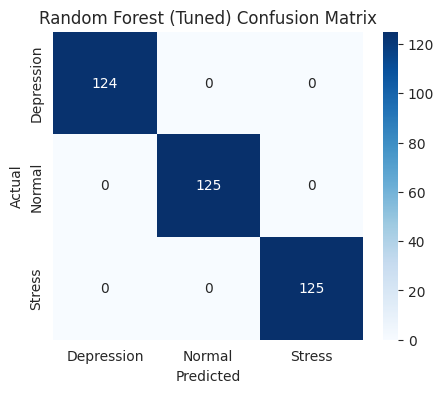

1.0

In [ ]:
y_pred_best_rf = best_rf.predict(X_test)
evaluate_model(y_test, y_pred_best_rf, "Random Forest (Tuned)")

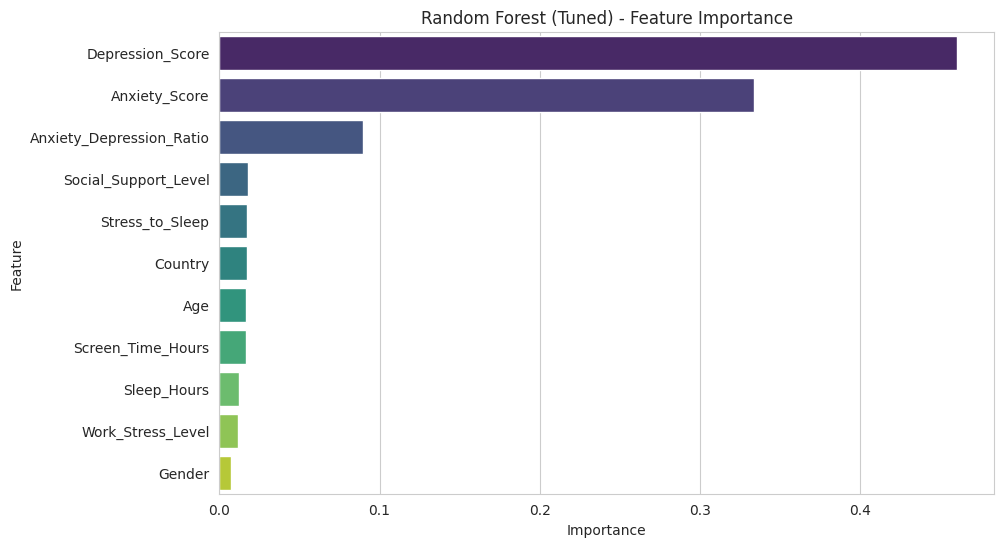

In [ ]:
plot_feature_importance(best_rf, "Random Forest (Tuned)")


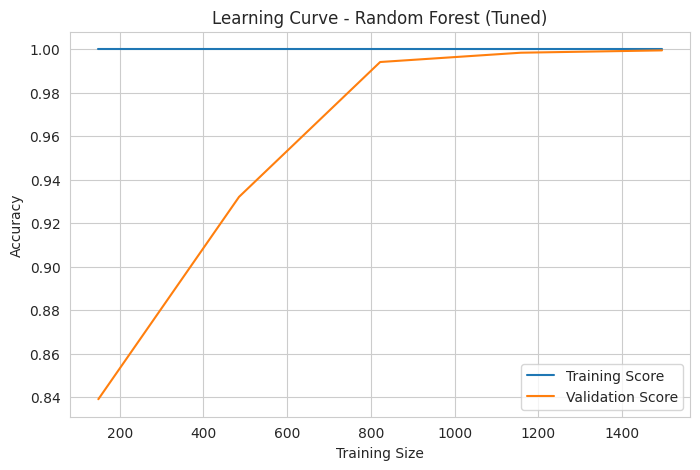

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_rf, X_res, y_res, cv=5, train_sizes=np.linspace(0.1,1.0,5), scoring='accuracy')
plt.figure(figsize=(8,5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Random Forest (Tuned)")
plt.legend()
plt.show()

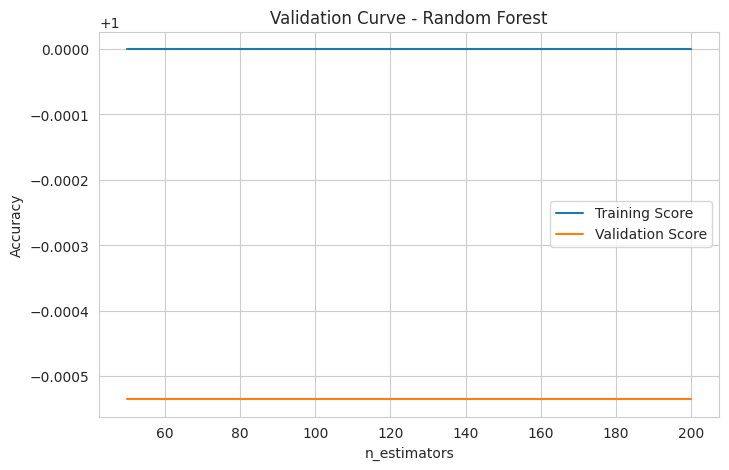

In [ ]:
param_range = [50,100,150,200]
train_scores, test_scores = validation_curve(RandomForestClassifier(random_state=42), X_res, y_res, param_name="n_estimators", param_range=param_range, cv=3, scoring="accuracy")
plt.figure(figsize=(8,5))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("Validation Curve - Random Forest")
plt.legend()
plt.show()



--- Voting Classifier ---
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

  Depression       1.00      1.00      1.00       124
      Normal       1.00      1.00      1.00       125
      Stress       1.00      1.00      1.00       125

    accuracy                           1.00       374
   macro avg       1.00      1.00      1.00       374
weighted avg       1.00      1.00      1.00       374



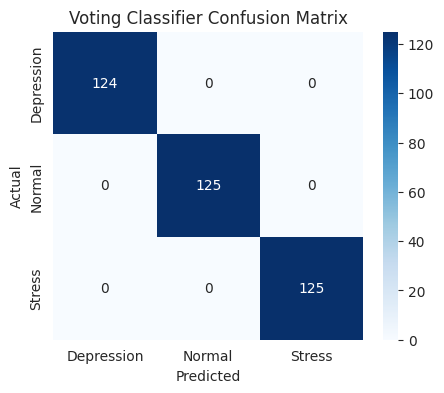

1.0

In [ ]:
voting_clf = VotingClassifier(estimators=[
    ('lr', models['Logistic Regression']),
    ('dt', models['Decision Tree']),
    ('rf', best_rf),
    ('xgb', models['XGBoost'])
], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
evaluate_model(y_test, y_pred_voting, "Voting Classifier")

In [ ]:
misclassified_idx = np.where(y_pred_best_rf != y_test)[0]
print(f"Number of misclassified samples (Tuned RF): {len(misclassified_idx)}")
print("Example misclassified samples:")
print(X_test[misclassified_idx[:5]])

Number of misclassified samples (Tuned RF): 0
Example misclassified samples:
[]


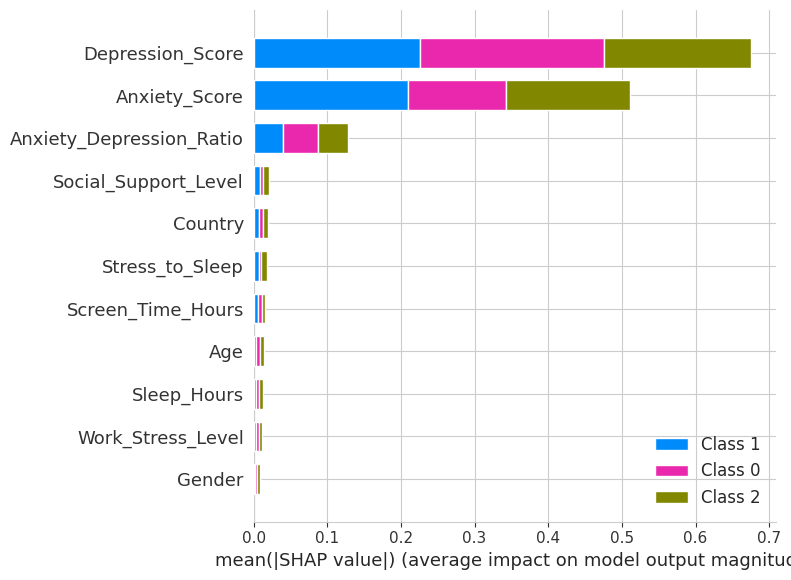

In [ ]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=True)


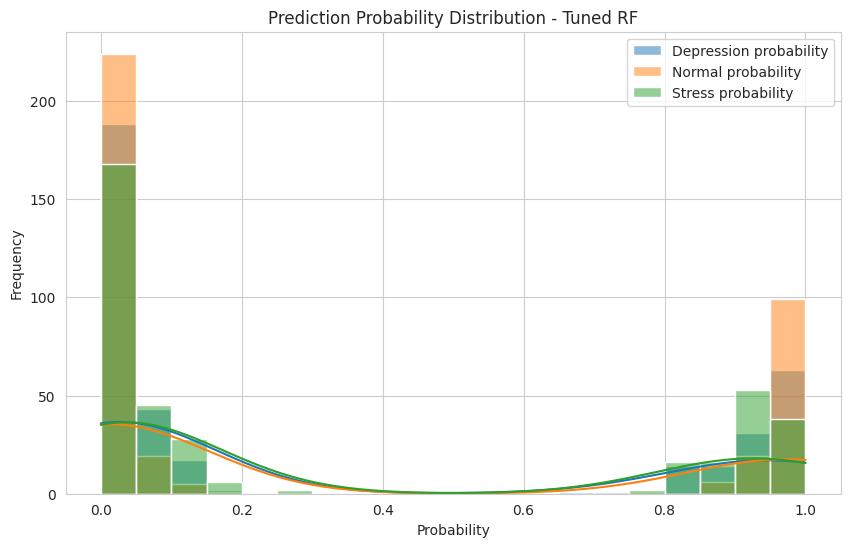

In [ ]:
y_proba = best_rf.predict_proba(X_test)
plt.figure(figsize=(10,6))
for i, cls in enumerate(le_target.classes_):
    sns.histplot(y_proba[:,i], kde=True, label=f"{cls} probability", bins=20)
plt.title("Prediction Probability Distribution - Tuned RF")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
joblib.dump(best_rf, "Tuned_RandomForest_MentalHealth.pkl")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
loaded_model = joblib.load("Tuned_RandomForest_MentalHealth.pkl")
y_pred_loaded = loaded_model.predict(X_test)
print("Loaded model accuracy:", accuracy_score(y_test, y_pred_loaded))

Loaded model accuracy: 1.0


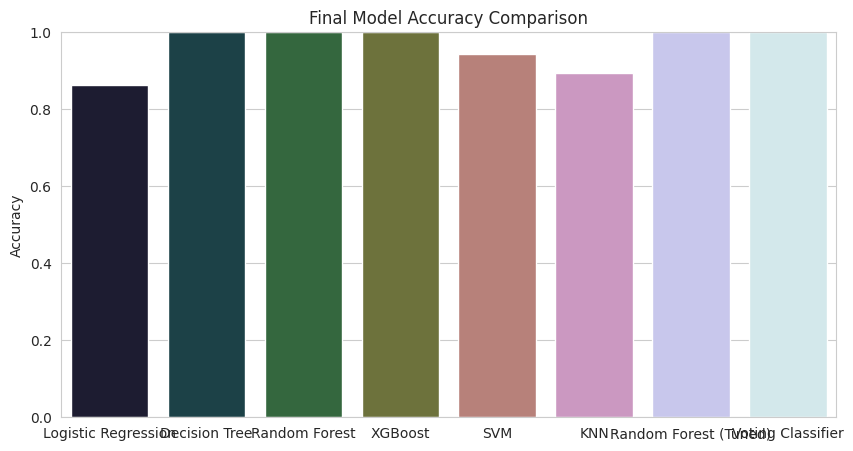

In [ ]:
final_accuracies = model_accuracies.copy()
final_accuracies["Random Forest (Tuned)"] = accuracy_score(y_test, y_pred_best_rf)
final_accuracies["Voting Classifier"] = accuracy_score(y_test, y_pred_voting)
plt.figure(figsize=(10,5))
sns.barplot(x=list(final_accuracies.keys()), y=list(final_accuracies.values()), palette='cubehelix')
plt.title("Final Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


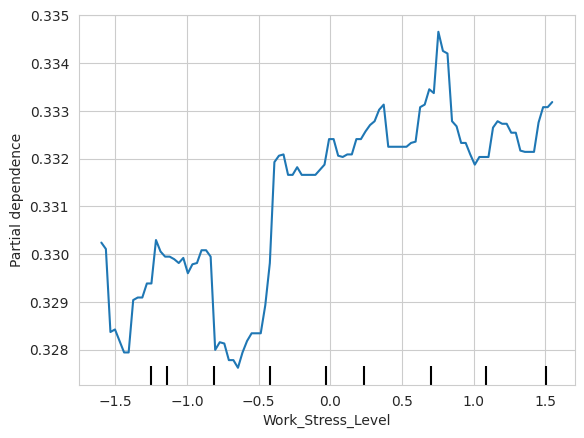

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Example for feature 'Work_Stress_Level'
PartialDependenceDisplay.from_estimator(best_rf, X_test, features=['Work_Stress_Level'], feature_names=X.columns, target=0)
plt.show()

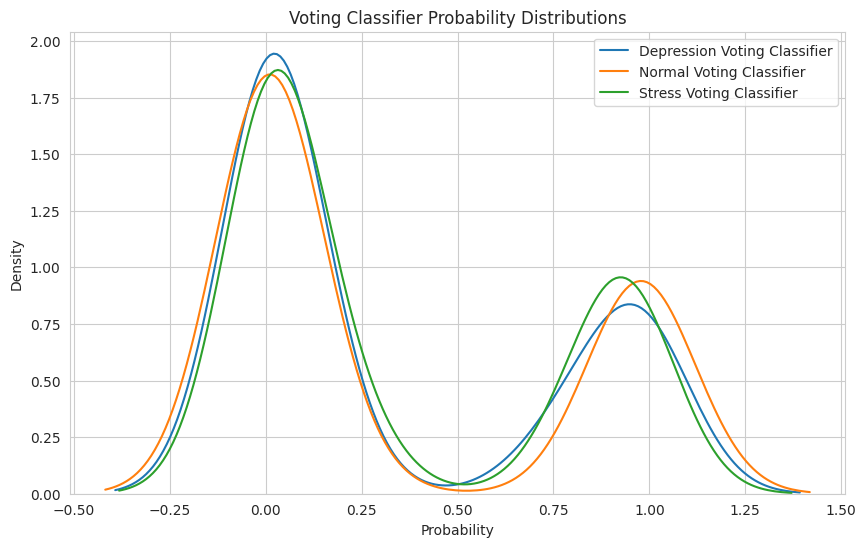

In [ ]:
y_proba_voting = voting_clf.predict_proba(X_test)
plt.figure(figsize=(10,6))
for i, cls in enumerate(le_target.classes_):
    sns.kdeplot(y_proba_voting[:,i], label=f"{cls} Voting Classifier")
plt.title("Voting Classifier Probability Distributions")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
summary_df = pd.DataFrame.from_dict(final_accuracies, orient='index', columns=['Accuracy']).sort_values(by='Accuracy', ascending=False)
print("Final Summary Table:\n", summary_df)


Final Summary Table:
                        Accuracy
Decision Tree          1.000000
Random Forest          1.000000
XGBoost                1.000000
Voting Classifier      1.000000
Random Forest (Tuned)  1.000000
SVM                    0.943850
KNN                    0.893048
Logistic Regression    0.863636


In [ ]:
joblib.dump(best_rf, "Tuned_RandomForest_MentalHealth.pkl")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
print(" Full ML Workflow Completed Successfully!")

 Full ML Workflow Completed Successfully!
